In [1]:
import torch
import numpy as np
import lightgbm as lgb
import pandas as pd
import joblib
from pathlib import Path

def create_sequences_multi_step(X, y, context_len=45, horizon=7):
    X_seq, y_seq = [], []
    for i in range(context_len, len(X) - horizon + 1):
        X_seq.append(X.iloc[i - context_len:i].values)
        y_seq.append(y.iloc[i:i + horizon].values.flatten())
    return np.array(X_seq), np.array(y_seq)

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)


In [3]:
def gold_transformer(data, target="val_volumeutilcon", cat_col="id_reservatorio"):
    train_list, test_list = [], []

    for rid, group in data.groupby(cat_col):
        group = group.sort_values(["ano", "mes", "dia"])
        split_idx = int(len(group) * 0.7)

        train_part = group.iloc[:split_idx]
        test_part = group.iloc[split_idx:]

        # Média incremental como feature
        train_part["id_media"] = train_part[target].expanding().mean().shift(1)
        global_mean = train_part[target].mean()
        train_part["id_media"].fillna(global_mean, inplace=True)

        # Expansão para incluir test
        full_series = pd.concat([train_part, test_part])
        full_series["id_media"] = full_series[target].expanding().mean().shift(1)

        test_part["id_media"] = full_series.loc[test_part.index, "id_media"]
        test_part["id_media"].fillna(global_mean, inplace=True)

        train_list.append(train_part)
        test_list.append(test_part)

    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    test_df.fillna(0, inplace=True)

    # Features
    features = [
        "id_media",
        "val_volmax",
        "ear_reservatorio_percentual_lag1",
        "ear_reservatorio_percentual_lag7",
        "ear_reservatorio_percentual_roll7",
        "dia",
        "mes",
        "ano"
    ]

    X_train = train_df[features]
    y_train = train_df[[target]]

    X_test = test_df[features]
    y_test = test_df[[target]]

    X_train_seq, y_train_seq = create_sequences_multi_step(X_train, y_train)
    X_test_seq, y_test_seq = create_sequences_multi_step(X_test, y_test)

    return X_train_seq, y_train_seq, X_test_seq, y_test_seq

def train_lgbm(X, y, n_lags=45, horizon=7):
    X = X.reshape(X.shape[0], n_lags * X.shape[2])
    y_df = pd.DataFrame(y, columns=[f"t+{i+1}" for i in range(horizon)])

    models = {}
    for step in range(horizon):
        print(f"Treinando modelo para t+{step+1}")
        y_step = y_df.iloc[:, step]
        train_data = lgb.Dataset(X, label=y_step)

        params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.05,
            "num_leaves": 31
        }

        model = lgb.train(params, train_data, num_boost_round=50)
        models[f"t+{step+1}"] = model

        joblib.dump(model, MODELS_DIR / f"lgbm_model_t{step+1}.pkl")

    return models

def lgb_predictor(context_window: np.ndarray, horizon=7, n_lags=45, n_features=8) -> np.ndarray:
    preds = []

    # context_window deve ser (45, 8)
    if context_window.shape != (n_lags, n_features):
        raise ValueError(f"Esperado shape {(n_lags, n_features)}, mas recebi {context_window.shape}")

    # Achatar para (1, 360)
    current_window = context_window.reshape(1, -1)

    for step in range(1, horizon + 1):
        model = joblib.load(MODELS_DIR / f"lgbm_model_t{step}.pkl")
        pred = model.predict(current_window)[0]
        preds.append(float(pred))

        flat = current_window.reshape(n_lags, n_features)
        flat[-1, 0] = pred  # Atualiza a feature alvo

        current_window = flat.reshape(1, -1)

    return np.array(preds)



In [4]:
df = pd.read_csv('C:/Users/luis2/OneDrive/Documentos/challenge-ML/dados/resultado_unificado_normalized_clean.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499543 entries, 0 to 499542
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ear_reservatorio_percentual        488167 non-null  float64
 1   ear_total_mwmes                    499543 non-null  float64
 2   val_volmax                         499543 non-null  float64
 3   id_reservatorio                    499543 non-null  object 
 4   val_volumeutilcon                  499543 non-null  float64
 5   ear_reservatorio_percentual_lag1   488164 non-null  float64
 6   ear_reservatorio_percentual_lag7   488146 non-null  float64
 7   ear_reservatorio_percentual_lag14  488125 non-null  float64
 8   ear_reservatorio_percentual_roll7  488143 non-null  float64
 9   ear_reservatorio_percentual_diff1  488163 non-null  float64
 10  ear_total_mwmes_lag1               499542 non-null  float64
 11  ear_total_mwmes_lag7               4995

In [5]:
import warnings
warnings.filterwarnings("ignore")

X_train, y_train, X_test, y_test = gold_transformer(df)
models = train_lgbm(X_train, y_train, n_lags=45, horizon=7)

KeyboardInterrupt: 

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

def evaluate_lgbm(models_dir, X_test, y_test, horizon=7, n_lags=45, n_features=8):
    all_preds, all_true = [], []

    for seq, y_true in zip(X_test, y_test):
        preds = lgb_predictor(seq, horizon=horizon, n_lags=n_lags, n_features=n_features)
        all_preds.append(preds)
        all_true.append(y_true.flatten())

    all_preds = np.array(all_preds)  # shape: (n_samples, horizon)
    all_true = np.array(all_true)    # shape: (n_samples, horizon)

    results = {}

    # Métricas por horizonte
    for step in range(horizon):
        mse = mean_squared_error(all_true[:, step], all_preds[:, step])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_true[:, step], all_preds[:, step])

        results[f"t+{step+1}"] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae
        }

    # Métricas agregadas
    mse_total = mean_squared_error(all_true.flatten(), all_preds.flatten())
    rmse_total = np.sqrt(mse_total)
    mae_total = mean_absolute_error(all_true.flatten(), all_preds.flatten())
    r2 = r2_score(all_true.flatten(), all_preds.flatten())

    results["Overall"] = {
        "MSE": mse_total,
        "RMSE": rmse_total,
        "MAE": mae_total,
        "R2": r2
    }

    return results, all_preds, all_true


metrics, preds, trues = evaluate_lgbm(
    MODELS_DIR, X_test[:1000], y_test[:1000], horizon=7, n_lags=45, n_features=8
)

for step, vals in metrics.items():
    print(f"\n== {step} ==")
    for k, v in vals.items():
        print(f"{k}: {v:.4f}")



== t+1 ==
MSE: 0.0012
RMSE: 0.0350
MAE: 0.0161

== t+2 ==
MSE: 0.0011
RMSE: 0.0338
MAE: 0.0167

== t+3 ==
MSE: 0.0015
RMSE: 0.0381
MAE: 0.0205

== t+4 ==
MSE: 0.0015
RMSE: 0.0389
MAE: 0.0207

== t+5 ==
MSE: 0.0015
RMSE: 0.0391
MAE: 0.0212

== t+6 ==
MSE: 0.0017
RMSE: 0.0415
MAE: 0.0227

== t+7 ==
MSE: 0.0021
RMSE: 0.0456
MAE: 0.0262

== Overall ==
MSE: 0.0015
RMSE: 0.0390
MAE: 0.0206
R2: 0.7746


In [ ]:
print(preds.shape)
print(trues.shape)

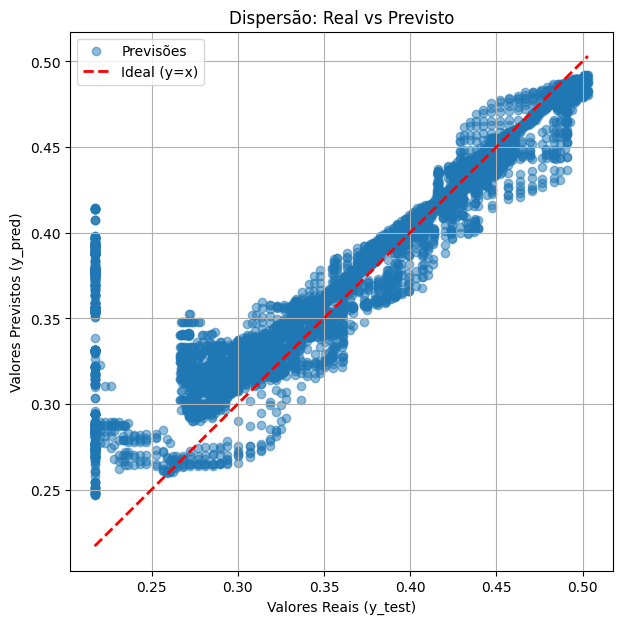

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(trues, preds, alpha=0.5, label="Previsões")
plt.plot([trues.min(), trues.max()],
         [trues.min(), trues.max()],
         'r--', lw=2, label="Ideal (y=x)")

plt.xlabel("Valores Reais (y_test)")
plt.ylabel("Valores Previstos (y_pred)")
plt.title("Dispersão: Real vs Previsto")
plt.legend()
plt.grid(True)
plt.show()